In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
import os
import time
import data
import model
from IPython.display import clear_output

AUTOTUNE = tf.data.experimental.AUTOTUNE

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-_vgasy_t because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_W = 256
IMG_H = 256
CHANNELS = 3

In [3]:
train_a_ds, train_b_ds = data.load_train_data()

In [4]:
sample_a = next(iter(train_a_ds))
sample_b = next(iter(train_b_ds))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


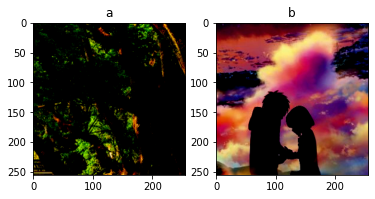

(1, 256, 256, 3) (1, 256, 256, 3)


In [5]:
plt.subplot(121)
plt.title("a")
plt.imshow(sample_a[0])
plt.subplot(122)
plt.title("b")
plt.imshow(sample_b[0])
plt.show()
print(sample_a.shape,sample_b.shape)

In [6]:
generator_g = model.generator(CHANNELS, norm_type='instancenorm')
generator_f = model.generator(CHANNELS, norm_type='instancenorm')
discriminator_x = model.discriminator(CHANNELS, norm_type='instancenorm', target=False)
discriminator_y = model.discriminator(CHANNELS, norm_type='instancenorm', target=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


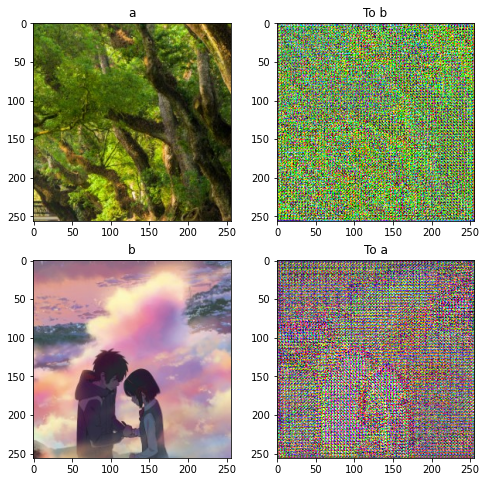

In [7]:
to_b = generator_g(sample_a)
to_a = generator_f(sample_b)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_a, to_b, sample_b, to_a]
title = ['a', 'To b', 'b', 'To a']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
    else:
        plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

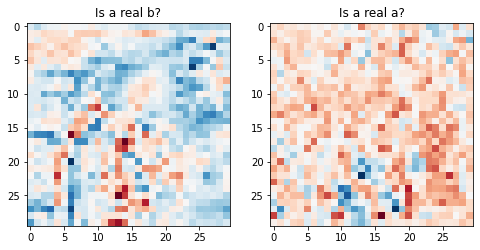

In [8]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real b?')
plt.imshow(discriminator_y(sample_b)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real a?')
plt.imshow(discriminator_x(sample_a)[0, ..., -1], cmap='RdBu_r')

plt.show()

In [9]:
LAMBDA = 10

In [10]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [11]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

In [12]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

In [13]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

In [14]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [15]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [16]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [17]:
def generate_save_images(model, inp, tar, idx):
    pred = model(inp)

    plt.figure(figsize=(12, 12))

    display_list = [inp[0], pred[0], tar[0]]
    title = ['Input Image', 'Predicted Image', 'Target Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5, cmap="gray")
        plt.axis('off')

    plt.savefig('train_img/image_{:04d}.png'.format(idx))
    plt.show()

In [18]:
@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

In [19]:
EPOCHS = 10

In [ ]:
for epoch in range(EPOCHS):
    start = time.time()

    n = 0
    for image_x, image_y in tf.data.Dataset.zip((train_a_ds, train_b_ds)):
        train_step(image_x, image_y)
        if n % 10 == 0:
            print ('.', end='')
        n+=1

    clear_output(wait=True)
    print(n)

    generate_save_images(generator_g, sample_a, sample_b, epoch)

    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch + 1, ckpt_save_path))
    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))

............

In [ ]:
generator_g.save("generator_g")
generator_f.save("generator_f")
discriminator_x.save("discriminator_x")
discriminator_y.save("discriminator_y")